## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [3]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [4]:
def draw_graph():
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [5]:
def cal_loss():
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = model(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t += 1
    
    return mmm / t

In [6]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

In [19]:
from torch.optim.lr_scheduler import StepLR, MultiStepLR

In [ ]:
"""
Train with the grid
"""
gamma = 10
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[300, 400], gamma=0.1)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
for k in range(1000):
    n1 = 0
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y #+ gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
    loss /= n1
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if gamma < 500:
        gamma = gamma * 1.01
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    
    scheduler.step()
    optimizer.step()
    

0  epoch, loss:  -0.0068213367
0  epoch, regularization loss:  0.002293489
0  loss to real solution:  0.12179881662609483
1  epoch, loss:  -0.046784833
1  epoch, regularization loss:  0.01421241
1  loss to real solution:  0.10937666784528739
2  epoch, loss:  -0.12826979
2  epoch, regularization loss:  0.042608812
2  loss to real solution:  0.1034846502561661
3  epoch, loss:  -0.24259797
3  epoch, regularization loss:  0.095514655
3  loss to real solution:  0.14355457657403117
4  epoch, loss:  -0.362577
4  epoch, regularization loss:  0.17508999
4  loss to real solution:  0.2560360669284771
5  epoch, loss:  -0.47553378
5  epoch, regularization loss:  0.27088732
5  loss to real solution:  0.3658569193499648
6  epoch, loss:  -0.5643064
6  epoch, regularization loss:  0.35767305
6  loss to real solution:  0.4502819698876505
7  epoch, loss:  -0.6106149
7  epoch, regularization loss:  0.40309274
7  loss to real solution:  0.4925658229424639
8  epoch, loss:  -0.6142001
8  epoch, regularizatio

69  epoch, loss:  -0.3069932
69  epoch, regularization loss:  0.12523289
69  loss to real solution:  0.2329120865933764
70  epoch, loss:  -0.29458153
70  epoch, regularization loss:  0.114197314
70  loss to real solution:  0.21934219839871888
71  epoch, loss:  -0.28684506
71  epoch, regularization loss:  0.108412944
71  loss to real solution:  0.21087872349180975
72  epoch, loss:  -0.28466427
72  epoch, regularization loss:  0.10806182
72  loss to real solution:  0.2085901120237982
73  epoch, loss:  -0.28726748
73  epoch, regularization loss:  0.112051874
73  loss to real solution:  0.2113158309919658
74  epoch, loss:  -0.2921646
74  epoch, regularization loss:  0.118179515
74  loss to real solution:  0.21637859662246092
75  epoch, loss:  -0.2948716
75  epoch, regularization loss:  0.12180228
75  loss to real solution:  0.21905590770712235
76  epoch, loss:  -0.2949171
76  epoch, regularization loss:  0.12282494
76  loss to real solution:  0.2192956985346374
77  epoch, loss:  -0.2920996

136  epoch, loss:  -0.1894098
136  epoch, regularization loss:  0.07778862
136  loss to real solution:  0.09963476901844003
137  epoch, loss:  -0.18310426
137  epoch, regularization loss:  0.07059761
137  loss to real solution:  0.09433630103658634
138  epoch, loss:  -0.17339976
138  epoch, regularization loss:  0.060737357
138  loss to real solution:  0.08639059028537327
139  epoch, loss:  -0.1713732
139  epoch, regularization loss:  0.058903463
139  loss to real solution:  0.08539704015017323
140  epoch, loss:  -0.17349567
140  epoch, regularization loss:  0.061310325
140  loss to real solution:  0.08922731909529573
141  epoch, loss:  -0.17985497
141  epoch, regularization loss:  0.067249976
141  loss to real solution:  0.09633009573750177
142  epoch, loss:  -0.18066604
142  epoch, regularization loss:  0.06807228
142  loss to real solution:  0.09887782160492191
143  epoch, loss:  -0.17513646
143  epoch, regularization loss:  0.062483396
143  loss to real solution:  0.095572683201725

202  epoch, loss:  -0.09941642
202  epoch, regularization loss:  0.018380817
202  loss to real solution:  0.033443448605836375
203  epoch, loss:  -0.1421987
203  epoch, regularization loss:  0.060784753
203  loss to real solution:  0.07067167883133964
204  epoch, loss:  -0.10744842
204  epoch, regularization loss:  0.024438271
204  loss to real solution:  0.0381764954721429
205  epoch, loss:  -0.11716276
205  epoch, regularization loss:  0.03321904
205  loss to real solution:  0.04742292652942739
206  epoch, loss:  -0.12513764
206  epoch, regularization loss:  0.041704666
206  loss to real solution:  0.056143155431440744
207  epoch, loss:  -0.11401447
207  epoch, regularization loss:  0.031779364
207  loss to real solution:  0.04581667502593378
208  epoch, loss:  -0.12479846
208  epoch, regularization loss:  0.04332019
208  loss to real solution:  0.05598670614973138
209  epoch, loss:  -0.116667636
209  epoch, regularization loss:  0.034687616
209  loss to real solution:  0.04781487767

267  epoch, loss:  -0.07618653
267  epoch, regularization loss:  0.008486049
267  loss to real solution:  0.014258399102657185
268  epoch, loss:  -0.10588134
268  epoch, regularization loss:  0.040385902
268  loss to real solution:  0.029734159760728095
269  epoch, loss:  -0.070696004
269  epoch, regularization loss:  0.0058547426
269  loss to real solution:  0.014830070163851026
270  epoch, loss:  -0.103017926
270  epoch, regularization loss:  0.036794696
270  loss to real solution:  0.028558184234275637
271  epoch, loss:  -0.08670505
271  epoch, regularization loss:  0.018227782
271  loss to real solution:  0.01627197727800562
272  epoch, loss:  -0.07559169
272  epoch, regularization loss:  0.010098564
272  loss to real solution:  0.01420057381656009
273  epoch, loss:  -0.105110966
273  epoch, regularization loss:  0.04365497
273  loss to real solution:  0.03280885752949296
274  epoch, loss:  -0.067356616
274  epoch, regularization loss:  0.006678581
274  loss to real solution:  0.01

332  epoch, loss:  -0.06769425
332  epoch, regularization loss:  0.011336308
332  loss to real solution:  0.022929566795802995
333  epoch, loss:  -0.07077323
333  epoch, regularization loss:  0.014273247
333  loss to real solution:  0.021206568595489146
334  epoch, loss:  -0.07389761
334  epoch, regularization loss:  0.01757503
334  loss to real solution:  0.01985380749418807
335  epoch, loss:  -0.075805105
335  epoch, regularization loss:  0.020207677
335  loss to real solution:  0.019082988125909972
336  epoch, loss:  -0.07637236
336  epoch, regularization loss:  0.02116628
336  loss to real solution:  0.018814602149261176
337  epoch, loss:  -0.07546409
337  epoch, regularization loss:  0.02014745
337  loss to real solution:  0.019009899101265014
338  epoch, loss:  -0.073620275
338  epoch, regularization loss:  0.017710485
338  loss to real solution:  0.019628577402933646
339  epoch, loss:  -0.07094542
339  epoch, regularization loss:  0.014870041
339  loss to real solution:  0.02061

397  epoch, loss:  -0.06337124
397  epoch, regularization loss:  0.009916419
397  loss to real solution:  0.023217562736997308
398  epoch, loss:  -0.063846536
398  epoch, regularization loss:  0.010476411
398  loss to real solution:  0.02286172826382129
399  epoch, loss:  -0.06399444
399  epoch, regularization loss:  0.010647373
399  loss to real solution:  0.022754064968927918
400  epoch, loss:  -0.06358464
400  epoch, regularization loss:  0.010356508
400  loss to real solution:  0.02292350190437112
401  epoch, loss:  -0.06350768
401  epoch, regularization loss:  0.010387285
401  loss to real solution:  0.022960073378691753
402  epoch, loss:  -0.06343338
402  epoch, regularization loss:  0.010384881
402  loss to real solution:  0.0230162248829937
403  epoch, loss:  -0.06332497
403  epoch, regularization loss:  0.010350455
403  loss to real solution:  0.023091191963750868
404  epoch, loss:  -0.06321236
404  epoch, regularization loss:  0.010286611
404  loss to real solution:  0.023184

462  epoch, loss:  -0.056520764
462  epoch, regularization loss:  0.00693199
462  loss to real solution:  0.028506791759342277
463  epoch, loss:  -0.05646659
463  epoch, regularization loss:  0.0069487607
463  loss to real solution:  0.02855516770836628
464  epoch, loss:  -0.056435313
464  epoch, regularization loss:  0.006974162
464  loss to real solution:  0.028593761739815197
465  epoch, loss:  -0.056363765
465  epoch, regularization loss:  0.007004588
465  loss to real solution:  0.02862573737979322
466  epoch, loss:  -0.056346685
466  epoch, regularization loss:  0.0070364177
466  loss to real solution:  0.02865427957182915
467  epoch, loss:  -0.056298718
467  epoch, regularization loss:  0.007066383
467  loss to real solution:  0.028682228807851082
468  epoch, loss:  -0.056269344
468  epoch, regularization loss:  0.007091435
468  loss to real solution:  0.028712112463747223
469  epoch, loss:  -0.056264933
469  epoch, regularization loss:  0.007108792
469  loss to real solution:  

527  epoch, loss:  -0.045659646
527  epoch, regularization loss:  0.0019745552
527  loss to real solution:  0.041099581133897695
528  epoch, loss:  -0.046613686
528  epoch, regularization loss:  0.0026684988
528  loss to real solution:  0.04015930866313522
529  epoch, loss:  -0.047378656
529  epoch, regularization loss:  0.0034809008
529  loss to real solution:  0.039230466650804936
530  epoch, loss:  -0.048394635
530  epoch, regularization loss:  0.004371242
530  loss to real solution:  0.03833870652979213
531  epoch, loss:  -0.048981775
531  epoch, regularization loss:  0.005294268
531  loss to real solution:  0.03751401470021806
532  epoch, loss:  -0.049645796
532  epoch, regularization loss:  0.0062048594
532  loss to real solution:  0.03676530121511205
533  epoch, loss:  -0.050233778
533  epoch, regularization loss:  0.00699025
533  loss to real solution:  0.03613792727806181
534  epoch, loss:  -0.050784864
534  epoch, regularization loss:  0.007583324
534  loss to real solution: 

592  epoch, loss:  -0.044921007
592  epoch, regularization loss:  0.0012338035
592  loss to real solution:  0.04028229267267557
593  epoch, loss:  -0.04557345
593  epoch, regularization loss:  0.0014873522
593  loss to real solution:  0.03966413025591539
594  epoch, loss:  -0.046125907
594  epoch, regularization loss:  0.0018341967
594  loss to real solution:  0.03897098355354609
595  epoch, loss:  -0.04694588
595  epoch, regularization loss:  0.0022921003
595  loss to real solution:  0.03821899539979713
596  epoch, loss:  -0.047770683
596  epoch, regularization loss:  0.0028679546
596  loss to real solution:  0.03744588578437307
597  epoch, loss:  -0.048453048
597  epoch, regularization loss:  0.0035534026
597  loss to real solution:  0.03668934244914075
598  epoch, loss:  -0.049214154
598  epoch, regularization loss:  0.0043147975
598  loss to real solution:  0.03599079925051844
599  epoch, loss:  -0.049764384
599  epoch, regularization loss:  0.005096708
599  loss to real solution: 

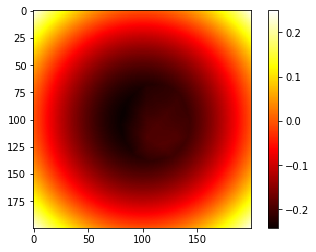

0.12344430849770638

In [18]:
draw_graph()
cal_loss()

In [99]:
# Calculate time for grid method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01 * learning_rate)


#start = time.time()
for k in range(100):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#stop = time.time()
#print(stop - start)

0  epoch, loss:  -0.042934492
0  epoch, regularization loss:  0.0018837771
0  loss to real solution:  0.018558336772336124
1  epoch, loss:  -0.04366216
1  epoch, regularization loss:  0.0028647736
1  loss to real solution:  0.017687089113560563
2  epoch, loss:  -0.042935114
2  epoch, regularization loss:  0.0020017799
2  loss to real solution:  0.018293959082514577
3  epoch, loss:  -0.04257084
3  epoch, regularization loss:  0.0014417644
3  loss to real solution:  0.018797035215368657
4  epoch, loss:  -0.042614598
4  epoch, regularization loss:  0.0014540836
4  loss to real solution:  0.01874425233177055
5  epoch, loss:  -0.04206595
5  epoch, regularization loss:  0.0010416269
5  loss to real solution:  0.01929395003334124
6  epoch, loss:  -0.041763987
6  epoch, regularization loss:  0.0007883444
6  loss to real solution:  0.019736964756269595
7  epoch, loss:  -0.041633297
7  epoch, regularization loss:  0.0006423191
7  loss to real solution:  0.02005165859434004
8  epoch, loss:  -0.04

KeyboardInterrupt: 

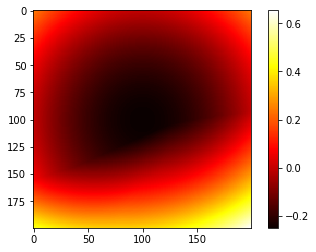

0.10208220987170931

In [19]:
#torch.save(model.state_dict(), '2/model.pkl')
draw_graph()
cal_loss()